Importing libraries and checking for GPU and training data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
from skimage.transform import resize
from IPython.display import Image 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

In [2]:
use_gpu = torch.cuda.is_available()

# CNN Architecture
Autoencoder architecture with encoder as Resnet-18 to take advantage of residual connections

In [4]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        # Encoder: Resnet-18
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract features from ResNet-gray for first 6 layers
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        # Decoder
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
        midlevel_features = self.midlevel_resnet(input)
        output = self.upsample(midlevel_features)
        
        return output

In [5]:
model = ColorizationNet()

In [6]:
criterion = nn.MSELoss(reduction = 'sum')

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

# Data Loading
Transform RGB images to LAB 

In [8]:
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img_original, img_ab, target

In [9]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('train/', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('validate/', val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

# Test
# val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
# val_imagefolder = GrayscaleImageFolder('Desktop/autoencoder/test', val_transforms)
# val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

# Utility Functions

In [10]:
class AverageMeter(object):
    # Utility function for timers
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):

    plt.clf()
    # combine channels
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() 
    # rescale for matplotlib
    color_image = color_image.transpose((1, 2, 0))  
    
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

# Training and Validation Functions

In [11]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()
    
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    end = time.time()
    already_saved_images = False
    
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)

        if use_gpu: 
            input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

        # Run model and record loss
        output_ab = model(input_gray) # throw away class predictions
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))

        # Save images to file
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 10)): # save at most 5 images
                save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)


        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy
        if i % 5 == 0:
            print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

In [12]:
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()
  
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
        # Use GPU if available
        if use_gpu: 
            input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below
        if i % 50 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                  epoch, i, len(train_loader), batch_time=batch_time,
                 data_time=data_time, loss=losses)) 

    print('Finished training epoch {}'.format(epoch))

In [13]:
if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()

In [14]:
# Make directories to store training artifacts
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints/', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

# Training

In [ ]:
# pretrained = torch.load('checkpoints/model-epoch-100-losses-0.002.pth', map_location=lambda storage, loc: storage)
# model.load_state_dict(pretrained)

for epoch in range(104, epochs+104):

    train(train_loader, model, criterion, optimizer, epoch)
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
        
  # Save checkpoint and replace old best model if current model is betterabs
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

# Testing and Inference

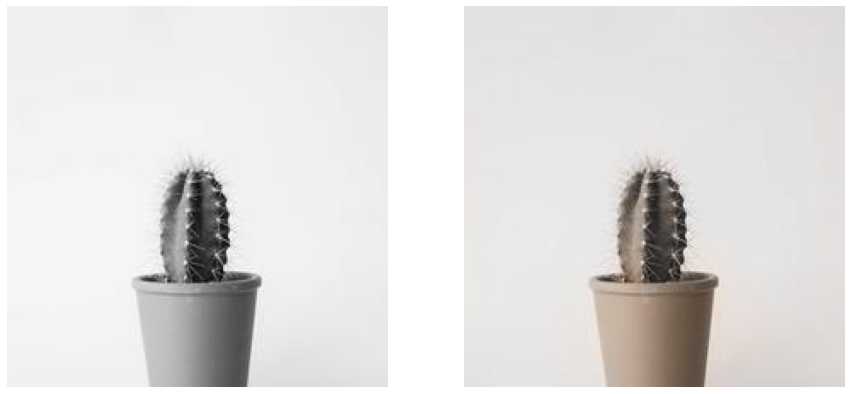

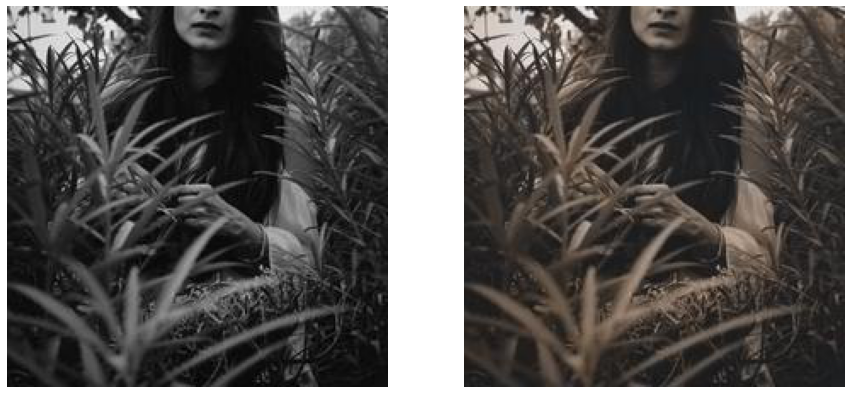

In [14]:
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-4-epoch-102.jpg', 'outputs/gray/img-4-epoch-102.jpg'),
               ('outputs/color/img-5-epoch-102.jpg', 'outputs/gray/img-5-epoch-102.jpg')]
for c, g in image_pairs:
    color = mpimg.imread(c)
    gray  = mpimg.imread(g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()

Get trained model onto the CPU for inference

In [16]:
pretrained = torch.load('checkpoints/model-epoch-109-losses-16962.837.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)
model = model.cpu()

In [17]:
def preprocess_input(img_path):
    gray = io.imread(img_path)
    gray = rgb2gray(gray)
    gray = resize(gray, (224, 224))

    gray_input = np.asarray(gray)
    gray_input = torch.from_numpy(gray_input).unsqueeze(0).float()
    gray_input = gray_input.unsqueeze(1)
    
    return gray_input

In [18]:
def postprocess_output(gray_input, output):
    plt.clf()

    # combine channels
    color_image = torch.cat((gray_input[0], output[0]), 0).detach().numpy() 
    # rescale for matplotlib
    color_image = color_image.transpose((1, 2, 0))

    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   

    color_image = lab2rgb(color_image.astype(np.float64))

    plt.imsave(arr=color_image, fname='output.jpeg')
    display(Image(filename='output.jpeg'))

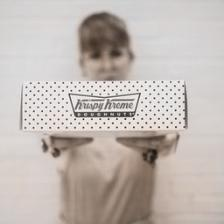

<Figure size 432x288 with 0 Axes>

In [19]:
model.eval()
gray_input = preprocess_input('validate/0/0OxqIk.jpg')
output = model(gray_input)
postprocess_output(gray_input, output)